In [160]:
# Imports

from dataExtraction import extract
from IPython.display import clear_output
from pprint import pprint

import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
from transformers import pipeline
from currency_converter import CurrencyConverter
import re
import statistics
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import numpy as np
# !pip install geopandas
import matplotlib.pyplot as plt
import geopandas as gpd

## Import Data

In [161]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head(10)

(6926, 8)


,title,company_name,location,via,description,job_highlights,detected_extensions,job_id
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,['As the data driven mindset is more and more ...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","[""Location: Dubai, UAE (We provide visa sponso...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,['Halen we in Nederland de klimaatdoelen op he...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,['As a Data Scientist in the Research & Invest...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,['Improving the working lives of millions of p...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...
5,Data Scientist,Adyen,Amsterdam,Nationale Vacaturebank,Functieomschrijving Data Analytics Amsterdam T...,"[""Functieomschrijving\n\nData Analytics Amster...","{'posted_at': '17 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...
6,Data Scientist bij Transavia,Transavia,Schiphol,Vacatures - Transa,Wij zoeken jou als Data Scientist Voor ons Str...,['Wij zoeken jou als Data Scientist\n\nVoor on...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBiaWogVH...
7,Data Science Lead - Amsterdam,Bynder,Amsterdam,Careers At Bynder,Bynder goes far beyond managing digital assets...,['Bynder goes far beyond managing digital asse...,"{'posted_at': '2 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgTGVhZCAtIE...
8,"LEAD DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Rotterdam,LinkedIn,Employment type: Full-time & Permanent Reports...,"[""Employment type: Full-time & Permanent\n\nRe...","{'posted_at': '1 day ago', 'schedule_type': 'F...",eyJqb2JfdGl0bGUiOiJMRUFEIERBVEEgU0NJRU5USVNUIC...
9,Data Science and Artificial Intelligence Fello...,Wageningen University & Research,Wageningen,AcademicTransfer,Are you a computer scientist with a PhD degree...,['Are you a computer scientist with a PhD degr...,{'posted_at': '2 days ago'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgYW5kIEFydG...


In [162]:
df['job_highlights'] = df['job_highlights'].replace(r'\n\n|\n•|\n|\\n|\\n•|•', '', regex=True)  # Remove new line char
df['job_highlights'] = df['job_highlights'].str.slice(2, -2)  # Remove [] and additional "" marks

## Salary Extraction

In [163]:
def extract_salary():
    qa_model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad') # Define the model 
    question = "What is the salary or salary range for the job?"  # Define the quesiton to be answered
    df['salary'] = df.apply(lambda x: "Not available" if qa_model(question=question, 
                                                                           context=(x['job_highlights'] + 
                                                                                    x['title'] + 
                                                                                    x['description']))['score'] < 0.3
                                                      else qa_model(question=question, 
                                                                              context=(x['job_highlights'] + 
                                                                                       x['title'] + 
                                                                                       x['description']))['answer'], axis=1)
    return df
    
df = extract_salary()

In [164]:
df['salary'] = df['salary'].str.replace(',', '', regex=True)  # Replace comma point in numerical values
df['salary'] = df['salary'].str.replace('.', '', regex=True)  # Replace dot point in numerical values

In [165]:
def find_specified_salary(x):    
    values = re.findall(r'\d+', str(x))  # Identify numerical values
    salary = 'Not available'
    salary_range = 'Not available'
    if len(values) == 1:  # Single numerical value, not a range
        salary = int(values[0]) 
        
    elif len(values) == 2:  # Two numerical values indicate a range
        min_salary = int(values[0])  # Min of salary range
        max_salary = int(values[1])  # Max of salary range
        salary = statistics.median([min_salary, max_salary])  # Calculate range median
        salary_range = str(min_salary) + "-" + str(max_salary)  # Format range
        
    return pd.Series([salary, salary_range])


df[['salary', 'salary_range']] = df['salary'].apply(find_specified_salary)

In [166]:
df.to_csv('data_salaries.csv')

In [167]:
test = df[df.salary != 'Not available']
print(len(test))

1181


There are approximately 1180 salaries extracted from the scraped job listings.

## Country Extraction
Identify the country in which the job location is located.
Countries are generally specified in the job description, location or highlights. Regex is used to identify key words indicative of job listing location, generating a country label for that job listing.

In [168]:
df['location'].value_counts()

United States             336
New York, NY, USA         302
San Francisco, CA, USA    154
Amsterdam                 148
Anywhere                  148
                         ... 
Giessen                     1
Rolle                       1
Essen                       1
Verl                        1
Cleveland, OH, USA          1
Name: location, Length: 837, dtype: int64

There exist approximately 830 unique locations. 
For each listing a country, and approximate coordinates are required in order to facilitate further working and visualizations. 
A rate limited GeoPy API can be utilized, however this is rate limited (explained below). Hence a cache can be created to minimize API requests, and easy access to location information.

### Location Cache
**Note: This should only be run of additional locations are found. The GeoPy API has a daily rate limit of 2500 requests per day.**

In [83]:
locations = df.location.unique()
locations_df = pd.DataFrame(data=locations, columns=['location'])

geolocator = Nominatim(user_agent="data_madness")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [86]:
def locator(x):
    if x['location'] is 'Anywhere':
        x['address'] = "Not available"
        x['latitude'] = "Not available"
        x['longitude'] = "Not available"
        return x
        
    location = geolocator.geocode(x['location'], language='en', exactly_one=True)
    if location is not None:
        x['address'] = location.address
        x['latitude'] = location.latitude
        x['longitude'] = location.longitude
    else:
        x['address'] = "Not available"
        x['latitude'] = "Not available"
        x['longitude'] = "Not available"
    return x

locations_df = locations_df.apply(locator, axis=1)
locations_df.head(10)

,location,address,latitude,longitude
0,Amsterdam,"Amsterdam, North Holland, Netherlands",52.37308,4.892453
1,Utrecht,"Utrecht, Netherlands",52.080986,5.127684
2,The Hague,"The Hague, South Holland, Netherlands",52.079984,4.311346
3,Maastricht,"Maastricht, Limburg, Netherlands",50.857985,5.696988
4,Schiphol,"Schiphol, Haarlemmermeer, North Holland, Nethe...",52.308039,4.762198
5,Rotterdam,"Rotterdam, South Holland, Netherlands",51.924442,4.47775
6,Wageningen,"Wageningen, Gelderland, Netherlands",51.968582,5.668298
7,Groningen,"Groningen, Netherlands",53.219065,6.568008
8,Netherlands,Netherlands,52.243498,5.634323
9,Dordrecht,"Dordrecht, South Holland, Netherlands",51.795881,4.677935


In [87]:
locations_df.to_csv('locations_cache.csv', index=False)

### Country Extraction
Extract the country, latitude, and longitude from the locations cache, and apply it to the dataframe in order to generate the required information for each listing.

In [169]:
locations_df = pd.read_csv('locations_cache.csv')
locations_df.set_index('location', inplace=True)  # Set location as index

In [170]:
countries = ['United Kingdom', 'France', 'Italy', 'Spain', 'Belgium',
            'Netherlands', 'Germany', 'Denmark', 'Switzerland', 'Austria',
            'Czech Republic', 'Canada', 'United States', 'South Africa',
            'Singapore', 'United Arab Emirates', 'Brazil', 'India', 
            'Portugal', 'Kenya', 'Argentina', 'Egypt', 'Suriname',
             'Mali', 'Malawi', 'Afghanistan', 'Philippines', 
             'Serbia', 'Not available']


def find_country(address):
    regex_pattern = '|'.join([f'{country}' for country in countries])  # Create regex pattern
    country = re.search(regex_pattern, address)
    if country == None:
        print(address)
    
    return country.group()

def identify_country(x):
    location = x['location']
    
    x['latitude'] = locations_df.loc[location, 'latitude']
    x['longitude'] = locations_df.loc[location, 'longitude']
    x['country'] = find_country(locations_df.loc[location, 'address'])
    return x

df = df.apply(identify_country, axis=1)

In [171]:
df.head()

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,latitude,longitude,country
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,52.3730796,4.8924534,Netherlands
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,Not available,52.080985600000005,5.12768396945229,Netherlands
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,Not available,52.0799838,4.3113461,Netherlands
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,Not available,50.85798545,5.6969881818221095,Netherlands
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,47500-90000,52.3730796,4.8924534,Netherlands


In [172]:
df['country'].value_counts()

United States     4256
Netherlands        437
Germany            302
Italy              277
Not available      265
France             254
Spain              250
United Kingdom     230
Belgium            198
Switzerland        151
Austria            150
Denmark            109
South Africa        19
Philippines          7
India                6
Afghanistan          5
Suriname             3
Argentina            3
Serbia               2
Mali                 1
Portugal             1
Name: country, dtype: int64

There exists a total of 22 countries in which job postings are positioned, with the majority occuring in the United States. 

## Currency Extraction
Extract the currency based on the extracted country, based on the below dictionary of ISO currencies. Libraries did not offer an expediant solution, hence the hardcoding of values below. Note the ISO format is chosen to enable currency conversion at a later date.

In [173]:
country_currency_mapping = {
    'United Kingdom': 'GBP', 
    'France': 'EUR',
    'Italy': 'EUR', 
    'Spain': 'EUR', 
    'Belgium': 'EUR',
    'Netherlands': 'EUR', 
    'Germany': 'EUR', 
    'Denmark': 'DKK', 
    'Switzerland': 'CHF', 
    'Austria': 'EUR',
    'Czech Republic': 'CZK', 
    'Canada': 'CAD', 
    'United States': 'USD', 
    'South Africa': 'ZAR',
    'Singapore': 'SGD', 
    'United Arab Emirates': 'AED', 
    'Brazil': 'BRL', 
    'India': 'INR', 
    'Portugal': 'EUR', 
    'Kenya': 'KES', 
    'Argentina': 'ARS', 
    'Egypt': 'EGP', 
    'Suriname': 'SRD',
    'Mali': 'XOF', 
    'Malawi': 'MWK', 
    'Afghanistan': 'AFN', 
    'Philippines': 'PHP', 
    'Serbia': 'RSD', 
    'Not available': 'Not available'
}

def extract_currency(x):
    x['currency'] = country_currency_mapping[x['country']]
    return x
    
    
df = df.apply(extract_currency, axis=1)

In [174]:
df.currency.value_counts()

USD              4256
EUR              1869
Not available     265
GBP               230
CHF               151
DKK               109
ZAR                19
PHP                 7
INR                 6
AFN                 5
SRD                 3
ARS                 3
RSD                 2
XOF                 1
Name: currency, dtype: int64

There is expected to be a degree of error, such that Jobs may be posted within a country, but offered from international origins, making the country of origin to currency mapping incorrect. However this occurance is a minority, and if extreme outlier occur due to this, the values can be transformed or removed.

In [175]:
df.to_csv('data_countries.csv')

## Currency Conversion
Convert from a multiplitude of currencie into Euros to enable accurate comparison.

In [176]:
def convert_currencies(x):
    if x['salary'] == 'Not available' or x['currency']== 'Not available':
        x['euro_value'] = 'Not available'
        return x
    
    conv = CurrencyConverter()
    x['euro_value'] = conv.convert(x['salary'], x['currency'], 'EUR')
    return x


df = df.apply(convert_currencies, axis=1)

In [178]:
df.tail()

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,latitude,longitude,country,currency,euro_value
6921,Lead Data Scientist/ Lead Machine Learning Eng...,Agoda,"Boston, MA, USA",LinkedIn,About Agoda Agoda is an online travel booking ...,"4+ years hands-on data science experience', 'E...","{'posted_at': '22 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJMZWFkIERhdGEgU2NpZW50aXN0Ly...,Not available,Not available,42.3554334,-71.060511,United States,USD,Not available
6922,Data Scientist,Stellantis,"Auburn Hills, MI, USA",LinkedIn,Your Mission The Global Analytics & Data Produ...,Successful influencing of non-technical peers ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,Not available,Not available,42.6875323,-83.2341028,United States,USD,Not available
6923,Junior Data Scientist (Secret Clearance Required),LMI,"Tysons, VA, USA",LinkedIn,Overview LMI is a consultancy dedicated to pow...,"Active DoD Secret clearance', 'Bachelor’s degr...","{'posted_at': '4 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,38.916509000000005,-77.22578977664253,United States,USD,Not available
6924,Data Scientist - Marketing,Hanna Andersson,United States,LinkedIn,"Hanna Andersson is a Portland, Oregon-based pr...","BA or BS focus in Business Administration, Mar...","{'posted_at': '2 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCAtIE1hcm...,120000.0,115000-125000,39.7837304,-100.445882,United States,USD,110967.264657
6925,Data Scientist with Security Clearance,ClearanceJobs,"Herndon, VA, USA",LinkedIn,Candidate MUST possess a TS/SCI clearance with...,Candidate MUST possess a TS/SCI clearance with...,"{'posted_at': '9 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCB3aXRoIF...,Not available,Not available,38.9695316,-77.3859479,United States,USD,Not available


## Skills Extraction

In [179]:
# Add empty columns
skills_list = []
with open("notes_and_prototypes/skills_list.txt") as file:
    while (line := file.readline().rstrip()):
        if line == "R":
            skills_list.append(" R ")
        else:
            skills_list.append(line)


# Replace blank spaces with underscores for dataframe columns
columns_list = []
for element in skills_list:
    columns_list.append(element.replace(" ", "_"))

for element in columns_list:
    df[element] = 0

/tmp/ipykernel_7656/1372371031.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[element] = 0
/tmp/ipykernel_7656/1372371031.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[element] = 0


In [180]:
# Find keywords and set columns accordingly

for i, row in df.iterrows():
    for keyword in skills_list:
        if keyword.lower() in df.at[i, "description"].lower():
            col = keyword.replace(" ", "_")
            df.at[i, col] = 1
# Print first results to check
df.head(10)

,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,salary_range,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,Not available,...,0,0,0,0,0,1,0,0,0,0
1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,Not available,...,0,0,0,0,0,1,0,0,0,0
2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,47500-90000,...,0,0,0,0,0,1,0,0,0,0
5,Data Scientist,Adyen,Amsterdam,Nationale Vacaturebank,Functieomschrijving Data Analytics Amsterdam T...,FunctieomschrijvingData Analytics AmsterdamThi...,"{'posted_at': '17 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,Not available,Not available,...,1,0,0,0,0,0,0,0,0,0
6,Data Scientist bij Transavia,Transavia,Schiphol,Vacatures - Transa,Wij zoeken jou als Data Scientist Voor ons Str...,Wij zoeken jou als Data ScientistVoor ons Stra...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBiaWogVH...,Not available,Not available,...,1,0,0,0,0,1,0,0,0,0
7,Data Science Lead - Amsterdam,Bynder,Amsterdam,Careers At Bynder,Bynder goes far beyond managing digital assets...,Bynder goes far beyond managing digital assets...,"{'posted_at': '2 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgTGVhZCAtIE...,Not available,Not available,...,0,0,0,0,0,1,0,0,0,0
8,"LEAD DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Rotterdam,LinkedIn,Employment type: Full-time & Permanent Reports...,Employment type: Full-time & PermanentReports ...,"{'posted_at': '1 day ago', 'schedule_type': 'F...",eyJqb2JfdGl0bGUiOiJMRUFEIERBVEEgU0NJRU5USVNUIC...,150000,Not available,...,0,0,0,0,0,1,0,0,0,0
9,Data Science and Artificial Intelligence Fello...,Wageningen University & Research,Wageningen,AcademicTransfer,Are you a computer scientist with a PhD degree...,Are you a computer scientist with a PhD degree...,{'posted_at': '2 days ago'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVuY2UgYW5kIEFydG...,Not available,Not available,...,0,0,0,0,0,0,0,0,0,0


## Export Data Frame to new CSV
With the new csv, all necessary information is extracted and will be the new basis to work with.

In [181]:
df.to_csv('data_clean.csv')

## EDA

In [182]:
df = pd.read_csv('data_clean.csv')
df.head()

,Unnamed: 0,title,company_name,location,via,description,job_highlights,detected_extensions,job_id,salary,...,Tensorflow,Teamwork,Time_series_analysis,Unsupervised_learning,UX_design,Visualization,Web_development,XML,YAML,YARN
0,0,Junior Data Scientist,ING,Amsterdam,ING Careers,As the data driven mindset is more and more em...,As the data driven mindset is more and more em...,"{'posted_at': '6 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJKdW5pb3IgRGF0YSBTY2llbnRpc3...,Not available,...,0,0,0,0,0,1,0,0,0,0
1,1,"JUNIOR DATA SCIENTIST - Dubai, UAE",Cobblestone Energy,Utrecht,LinkedIn,"Location: Dubai, UAE (We provide visa sponsors...","Location: Dubai, UAE (We provide visa sponsors...","{'posted_at': '4 hours ago', 'schedule_type': ...",eyJqb2JfdGl0bGUiOiJKVU5JT1IgREFUQSBTQ0lFTlRJU1...,60000,...,0,0,0,0,0,1,0,0,0,0
2,2,Data Scientist Mobiliteit,TNO,The Hague,TNO,Halen we in Nederland de klimaatdoelen op het ...,Halen we in Nederland de klimaatdoelen op het ...,"{'posted_at': '5 days ago', 'schedule_type': '...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBNb2JpbG...,Not available,...,0,0,0,0,0,0,0,0,0,0
3,3,Data Scientist Real Estate for Catella Investm...,Catella Investment Management Benelux,Maastricht,Limburgvac,As a Data Scientist in the Research & Investme...,As a Data Scientist in the Research & Investme...,"{'posted_at': '20 hours ago', 'schedule_type':...",eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCBSZWFsIE...,Not available,...,0,0,0,0,0,0,0,0,0,0
4,4,Data Scientist,Effectory,Amsterdam,Effectory Jobs,Improving the working lives of millions of peo...,Improving the working lives of millions of peo...,{'schedule_type': 'Full–time'},eyJqb2JfdGl0bGUiOiJEYXRhIFNjaWVudGlzdCIsImh0aW...,68750.0,...,0,0,0,0,0,1,0,0,0,0


In [183]:
locations_df = pd.read_csv('locations_cache.csv')
locations_df.set_index('location', inplace=True) 

In [184]:
location_count = df['location'].value_counts().reset_index()
location_count.rename(columns={'index': 'location', 'location': 'location_count'},
                                      inplace=True)

def retrieve_coordinates(x):
    location = x['location']
    x['latitude'] = locations_df.loc[location, 'latitude']
    x['longitude'] = locations_df.loc[location, 'longitude']
    return x

location_count = location_count.apply(retrieve_coordinates, axis=1)
location_count = location_count[location_count.latitude != 'Not available']

print(location_count.head())
print(location_count.shape)

                 location  location_count    latitude    longitude
0           United States             336  39.7837304  -100.445882
1       New York, NY, USA             302  40.7127281  -74.0060152
2  San Francisco, CA, USA             154  37.7790262  -122.419906
3               Amsterdam             148  52.3730796    4.8924534
5                  France             147   46.603354    1.8883335
(800, 4)


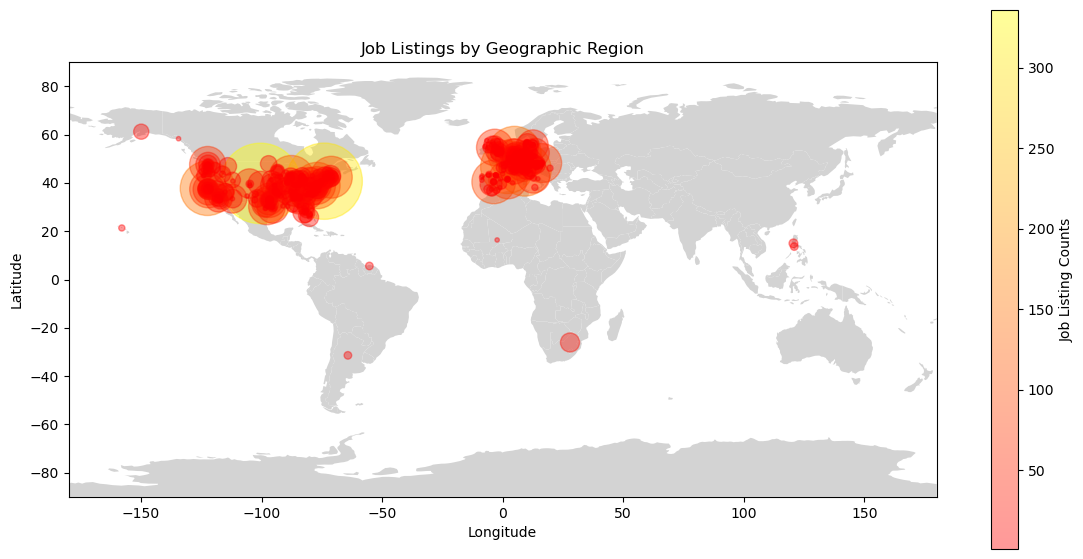

In [185]:
## Inspiration: https://towardsdatascience.com/easiest-way-to-plot-on-a-world-map-with-pandas-and-geopandas-325f6024949f ##

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


fix, ax = plt.subplots(figsize=(14, 7))
worldmap.plot(color="lightgrey", ax=ax)

lat = location_count['latitude'].astype(float)
long = location_count['longitude'].astype(float)
listing_count = location_count['location_count'].astype(float)


plt.scatter(x=long, y=lat, s=listing_count * 10, c=listing_count, alpha=0.4, cmap='autumn')
plt.colorbar(label='Job Listing Counts')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Job Listings by Geographic Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [186]:
# Create bar-chart for top n skills

skills_df = df.iloc[:, 13:]
skills_df_sum = pd.DataFrame(skills_df.sum())
skills_df_sum.rename(columns={ skills_df_sum.columns[0]: "amount" }, inplace = True)
skills_df_sum = skills_df_sum.sort_values(by=["amount"], ascending=False)

# Set n
n = 30
skills_df_sum_top = skills_df_sum.head(n)
skills_df_sum_top

# Create chart'>' not supported between instances of 'numpy.ndarray' and 'str'
sns.barplot(data=skills_df_sum_top, x=skills_df_sum_top.index, y="amount")
plt.xticks(rotation=90)
plt.xlabel("Skills")
plt.ylabel("Total Amount of Occurrences in Job Offers")
plt.title("Most Important Skills in Data Science")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

### Salary
When we inspect the salaries, we can see that there are outliers within the data, many of the salaries are at the very low end, with a few at the very high end.

In [193]:
salaries = df.salary[df.salary != 'Not available']
salaries = salaries.astype(float)
print(f"max salary: {salaries.max()}")
print(f"min salary: {salaries.min()}")
print(f"mean salary: {salaries.mean()}")

max salary: 203302425.0
min salary: 2.0
mean salary: 2971862.198983912


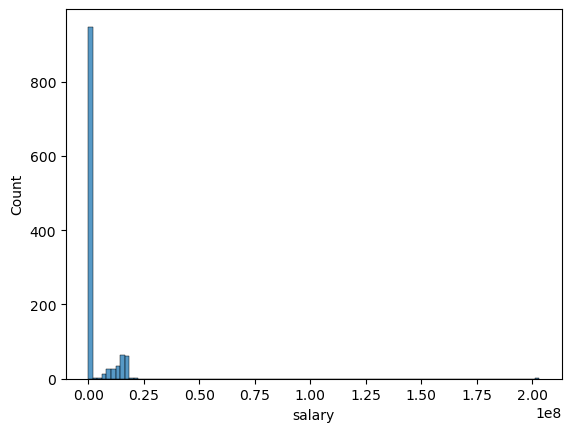

In [188]:
ax = sns.histplot(salaries, bins=100)

In [189]:
print(f"Salaries above 15000: {salaries[salaries>15000].count()}")
print(f"salaries below 15000: {salaries[salaries<=15000].count()}")

Salaries above 15000: 867
salaries below 15000: 314


<Axes: >

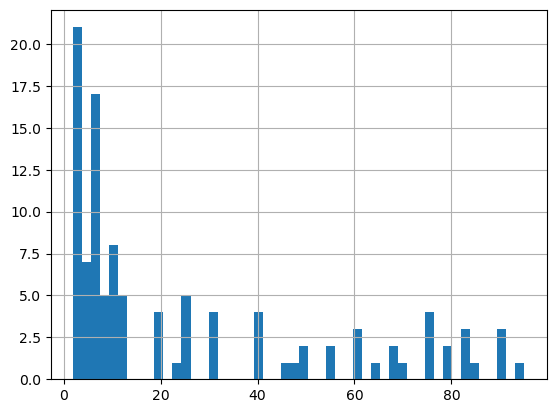

In [190]:
salary_hourly = salaries[salaries<100]
salary_hourly.hist(bins=50)

<Axes: >

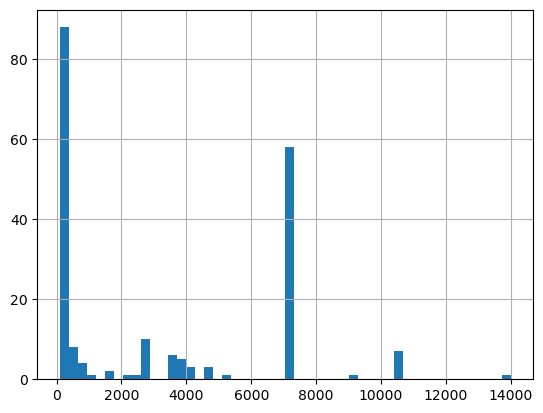

In [191]:
salary_monthly = salaries[salaries>100]
salary_monthly = salary_monthly[salary_monthly<15000]
salary_monthly.hist(bins=50)

<Axes: >

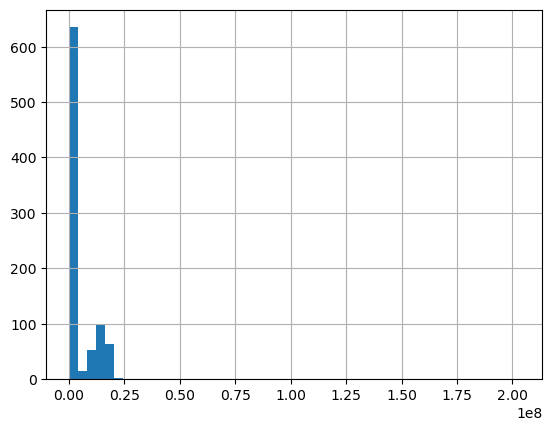

In [192]:
salary_yearly = salaries[salaries>15000]
salary_yearly.hist(bins=50)